In [1]:
# max_depth = 6
# min_child_weight = 3
# gamma = 0.2
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics   #Additional sklearn functions
from sklearn.model_selection import GridSearchCV   #Performing grid search

from xgboost import plot_tree
import pygraphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 4
rcParams['figure.dpi'] = 150

In [2]:
data = pd.read_csv('malicious.csv')
train = pd.get_dummies(data=data, columns=["CHARSET", "SERVER", "WHOIS_COUNTRY", "WHOIS_STATEPRO"])
train = train[train["APP_PACKETS"] > 0].dropna(axis=0)._get_numeric_data()

target = "Type"
IDcol = "ID"

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        
        print("Best iteration:")
        print(cvresult.iloc[-1])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [3]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]

Best iteration:
test-auc-mean     0.972217
test-auc-std      0.006296
train-auc-mean    0.999973
train-auc-std     0.000034
Name: 64, dtype: float64

Model Report
Accuracy : 0.9922
AUC Score (Train): 0.999947


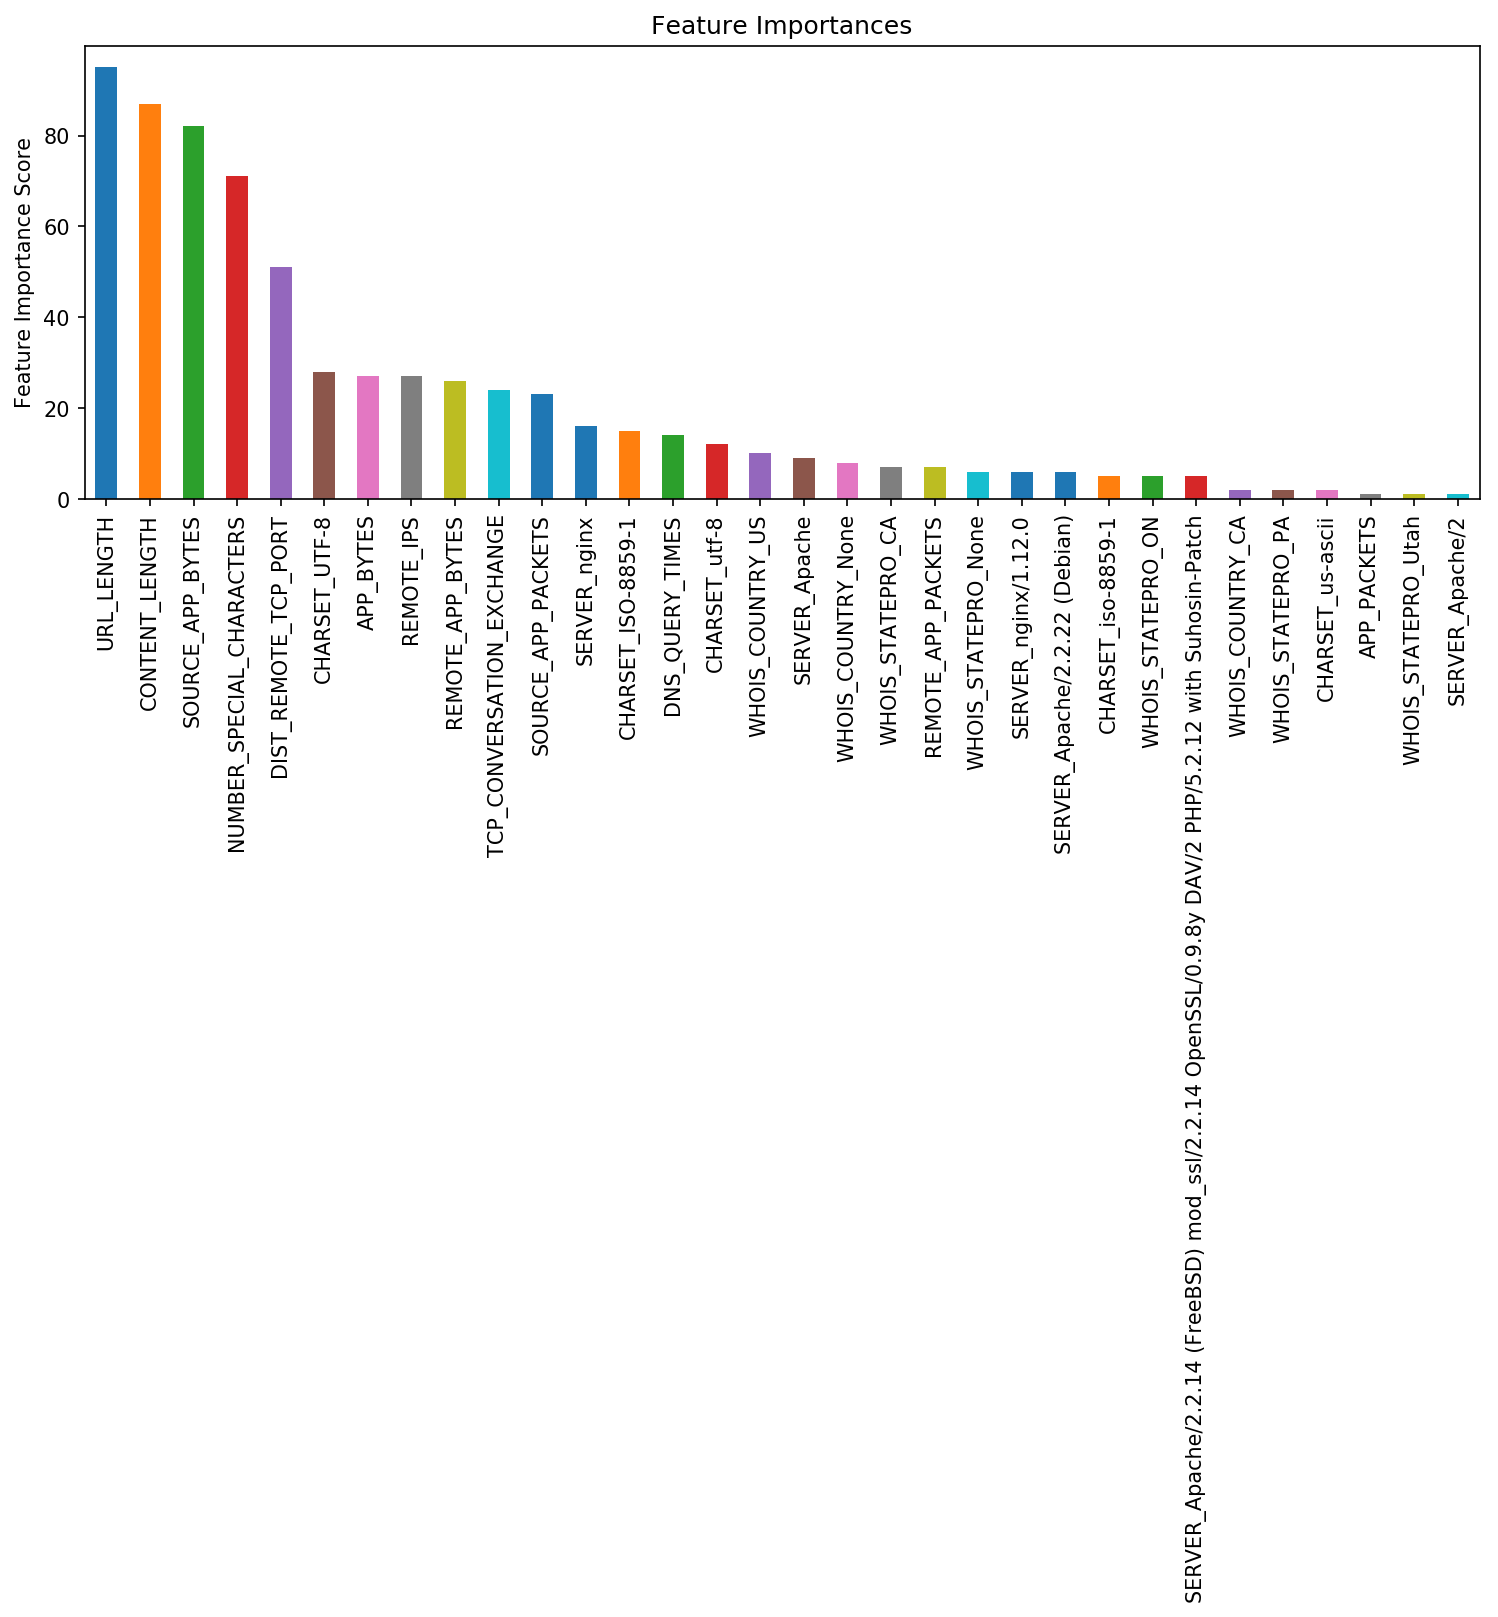

In [8]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, train, predictors)

In [3]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=65, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch1.best_params_)

print("\nGrid scores on development set:")

means = gsearch1.cv_results_['mean_test_score']
stds = gsearch1.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Best parameters set found on development set:
{'min_child_weight': 3, 'max_depth': 7}

Grid scores on development set:
0.931 (+/-0.033) for {'min_child_weight': 1, 'max_depth': 3}
0.928 (+/-0.061) for {'min_child_weight': 3, 'max_depth': 3}
0.922 (+/-0.056) for {'min_child_weight': 5, 'max_depth': 3}
0.926 (+/-0.060) for {'min_child_weight': 1, 'max_depth': 5}
0.933 (+/-0.045) for {'min_child_weight': 3, 'max_depth': 5}
0.927 (+/-0.054) for {'min_child_weight': 5, 'max_depth': 5}
0.932 (+/-0.039) for {'min_child_weight': 1, 'max_depth': 7}
0.939 (+/-0.034) for {'min_child_weight': 3, 'max_depth': 7}
0.926 (+/-0.052) for {'min_child_weight': 5, 'max_depth': 7}
0.929 (+/-0.051) for {'min_child_weight': 1, 'max_depth': 9}
0.939 (+/-0.034) for {'min_child_weight': 3, 'max_depth': 9}
0.926 (+/-0.052) for {'min_child_weight': 5, 'max_depth': 9}


In [5]:
param_test2 = {
 'max_depth':range(3,11),
 'min_child_weight':range(1,6)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch2.best_score_)
print(gsearch2.best_params_)

print("\nGrid scores on development set:")

means = gsearch2.cv_results_['mean_test_score']
stds = gsearch2.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
{'min_child_weight': 3, 'max_depth': 6}

Grid scores on development set:
0.931 (+/-0.033) for {'min_child_weight': 1, 'max_depth': 3}
0.924 (+/-0.052) for {'min_child_weight': 2, 'max_depth': 3}
0.928 (+/-0.061) for {'min_child_weight': 3, 'max_depth': 3}
0.925 (+/-0.069) for {'min_child_weight': 4, 'max_depth': 3}
0.922 (+/-0.056) for {'min_child_weight': 5, 'max_depth': 3}
0.933 (+/-0.036) for {'min_child_weight': 1, 'max_depth': 4}
0.932 (+/-0.038) for {'min_child_weight': 2, 'max_depth': 4}
0.933 (+/-0.062) for {'min_child_weight': 3, 'max_depth': 4}
0.936 (+/-0.062) for {'min_child_weight': 4, 'max_depth': 4}
0.925 (+/-0.054) for {'min_child_weight': 5, 'max_depth': 4}
0.926 (+/-0.060) for {'min_child_weight': 1, 'max_depth': 5}
0.929 (+/-0.035) for {'min_child_weight': 2, 'max_depth': 5}
0.933 (+/-0.045) for {'min_child_weight': 3, 'max_depth': 5}
0.934 (+/-0.061) for {'min_child_weight': 4, 'max_depth': 5}
0.927 (+/-0.054) for {'min_

In [7]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=65, max_depth=6,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch3.best_score_)
print(gsearch3.best_params_)

print("\nGrid scores on development set:")

means = gsearch3.cv_results_['mean_test_score']
stds = gsearch3.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
0.9402174092205244
{'gamma': 0.2}

Grid scores on development set:
0.940 (+/-0.034) for {'gamma': 0.0}
0.938 (+/-0.034) for {'gamma': 0.1}
0.940 (+/-0.031) for {'gamma': 0.2}
0.938 (+/-0.036) for {'gamma': 0.3}
0.936 (+/-0.045) for {'gamma': 0.4}


Best iteration:
test-auc-mean     0.971353
test-auc-std      0.005302
train-auc-mean    0.999540
train-auc-std     0.000459
Name: 115, dtype: float64


/Users/Matthew/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9891
AUC Score (Train): 0.999858


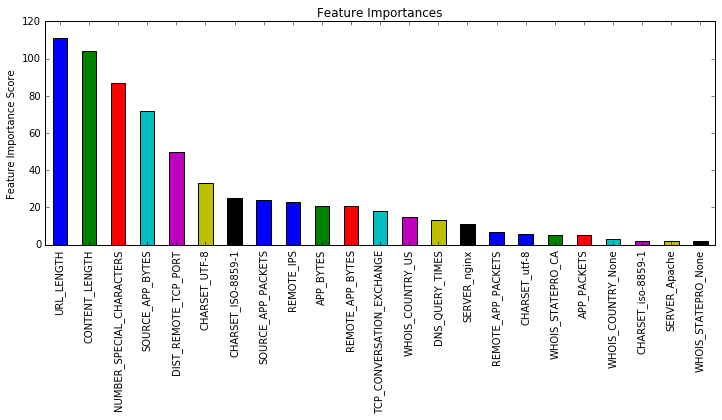

In [9]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [11]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=6,
 min_child_weight=3, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch4.best_score_)
print(gsearch4.best_params_)

print("\nGrid scores on development set:")

means = gsearch4.cv_results_['mean_test_score']
stds = gsearch4.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch4.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
0.9354126489640509
{'subsample': 0.8, 'colsample_bytree': 0.8}

Grid scores on development set:
0.928 (+/-0.035) for {'subsample': 0.6, 'colsample_bytree': 0.6}
0.930 (+/-0.039) for {'subsample': 0.7, 'colsample_bytree': 0.6}
0.935 (+/-0.043) for {'subsample': 0.8, 'colsample_bytree': 0.6}
0.929 (+/-0.048) for {'subsample': 0.9, 'colsample_bytree': 0.6}
0.930 (+/-0.040) for {'subsample': 0.6, 'colsample_bytree': 0.7}
0.929 (+/-0.045) for {'subsample': 0.7, 'colsample_bytree': 0.7}
0.931 (+/-0.044) for {'subsample': 0.8, 'colsample_bytree': 0.7}
0.926 (+/-0.054) for {'subsample': 0.9, 'colsample_bytree': 0.7}
0.930 (+/-0.062) for {'subsample': 0.6, 'colsample_bytree': 0.8}
0.930 (+/-0.048) for {'subsample': 0.7, 'colsample_bytree': 0.8}
0.935 (+/-0.036) for {'subsample': 0.8, 'colsample_bytree': 0.8}
0.931 (+/-0.047) for {'subsample': 0.9, 'colsample_bytree': 0.8}
0.930 (+/-0.056) for {'subsample': 0.6, 'colsample_bytree': 0.9}
0.930 (+/-0.0

In [12]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=6,
 min_child_weight=3, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch5.best_score_)
print(gsearch5.best_params_)

print("\nGrid scores on development set:")

means = gsearch5.cv_results_['mean_test_score']
stds = gsearch5.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch5.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
0.93841995088101
{'subsample': 0.75, 'colsample_bytree': 0.75}

Grid scores on development set:
0.938 (+/-0.030) for {'subsample': 0.75, 'colsample_bytree': 0.75}
0.933 (+/-0.040) for {'subsample': 0.8, 'colsample_bytree': 0.75}
0.933 (+/-0.049) for {'subsample': 0.85, 'colsample_bytree': 0.75}
0.931 (+/-0.052) for {'subsample': 0.75, 'colsample_bytree': 0.8}
0.935 (+/-0.036) for {'subsample': 0.8, 'colsample_bytree': 0.8}
0.929 (+/-0.047) for {'subsample': 0.85, 'colsample_bytree': 0.8}
0.934 (+/-0.048) for {'subsample': 0.75, 'colsample_bytree': 0.85}
0.936 (+/-0.046) for {'subsample': 0.8, 'colsample_bytree': 0.85}
0.927 (+/-0.051) for {'subsample': 0.85, 'colsample_bytree': 0.85}


In [14]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=6,
 min_child_weight=3, gamma=0.2, subsample=0.75, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch6.best_score_)
print(gsearch6.best_params_)

print("\nGrid scores on development set:")

means = gsearch6.cv_results_['mean_test_score']
stds = gsearch6.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch6.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
0.939127890685523
{'reg_alpha': 0.01}

Grid scores on development set:
0.938 (+/-0.030) for {'reg_alpha': 1e-05}
0.939 (+/-0.031) for {'reg_alpha': 0.01}
0.937 (+/-0.036) for {'reg_alpha': 0.1}
0.933 (+/-0.035) for {'reg_alpha': 1}
0.690 (+/-0.288) for {'reg_alpha': 100}


In [15]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=6,
 min_child_weight=3, gamma=0.2, subsample=0.75, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch7.best_score_)
print(gsearch7.best_params_)

print("\nGrid scores on development set:")

means = gsearch7.cv_results_['mean_test_score']
stds = gsearch7.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch7.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
0.9400204387743327
{'reg_alpha': 0.05}

Grid scores on development set:
0.938 (+/-0.030) for {'reg_alpha': 0}
0.938 (+/-0.032) for {'reg_alpha': 0.001}
0.939 (+/-0.032) for {'reg_alpha': 0.005}
0.939 (+/-0.031) for {'reg_alpha': 0.01}
0.940 (+/-0.035) for {'reg_alpha': 0.05}


In [19]:
param_test8 = {
 'reg_lambda':[1, 1+1e-5, 1+1e-2, 1+0.1, 2, 100]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=6,
 min_child_weight=3, gamma=0.2, subsample=0.75, colsample_bytree=0.75, reg_alpha=0.05,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch8.best_score_)
print(gsearch8.best_params_)

print("\nGrid scores on development set:")

means = gsearch8.cv_results_['mean_test_score']
stds = gsearch8.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch8.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
0.9400204387743327
{'reg_lambda': 1}

Grid scores on development set:
0.940 (+/-0.035) for {'reg_lambda': 1}
0.940 (+/-0.035) for {'reg_lambda': 1.00001}
0.936 (+/-0.039) for {'reg_lambda': 1.01}
0.938 (+/-0.040) for {'reg_lambda': 1.1}
0.935 (+/-0.028) for {'reg_lambda': 2}
0.919 (+/-0.046) for {'reg_lambda': 100}


In [6]:
param_test10 = {
 'n_estimators':[i for i in range(50,400,50)],
 'learning_rate':[i/100 for i in range(1,20)]
}
gsearch10 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=115, max_depth=6,
 min_child_weight=3, gamma=0.2, subsample=0.75, colsample_bytree=0.75, reg_alpha=0.05,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test10, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch10.fit(train[predictors],train[target])

print("Best parameters set found on development set:")
print(gsearch10.best_score_)
print(gsearch10.best_params_)

print("\nGrid scores on development set:")

means = gsearch10.cv_results_['mean_test_score']
stds = gsearch10.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gsearch10.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:
0.941093474427
{'learning_rate': 0.18, 'n_estimators': 50}

Grid scores on development set:
0.500 (+/-0.000) for {'learning_rate': 0.01, 'n_estimators': 0}
0.918 (+/-0.020) for {'learning_rate': 0.01, 'n_estimators': 50}
0.919 (+/-0.020) for {'learning_rate': 0.01, 'n_estimators': 100}
0.921 (+/-0.029) for {'learning_rate': 0.01, 'n_estimators': 150}
0.923 (+/-0.028) for {'learning_rate': 0.01, 'n_estimators': 200}
0.926 (+/-0.030) for {'learning_rate': 0.01, 'n_estimators': 250}
0.928 (+/-0.028) for {'learning_rate': 0.01, 'n_estimators': 300}
0.928 (+/-0.031) for {'learning_rate': 0.01, 'n_estimators': 350}
0.500 (+/-0.000) for {'learning_rate': 0.02, 'n_estimators': 0}
0.920 (+/-0.020) for {'learning_rate': 0.02, 'n_estimators': 50}
0.922 (+/-0.024) for {'learning_rate': 0.02, 'n_estimators': 100}
0.928 (+/-0.026) for {'learning_rate': 0.02, 'n_estimators': 150}
0.934 (+/-0.020) for {'learning_rate': 0.02, 'n_estimators': 200}
0.935 (+/-

Best iteration:
test-auc-mean     0.971675
test-auc-std      0.004774
train-auc-mean    0.998614
train-auc-std     0.000722
Name: 99, dtype: float64

Model Report
Accuracy : 0.9891
AUC Score (Train): 0.999307


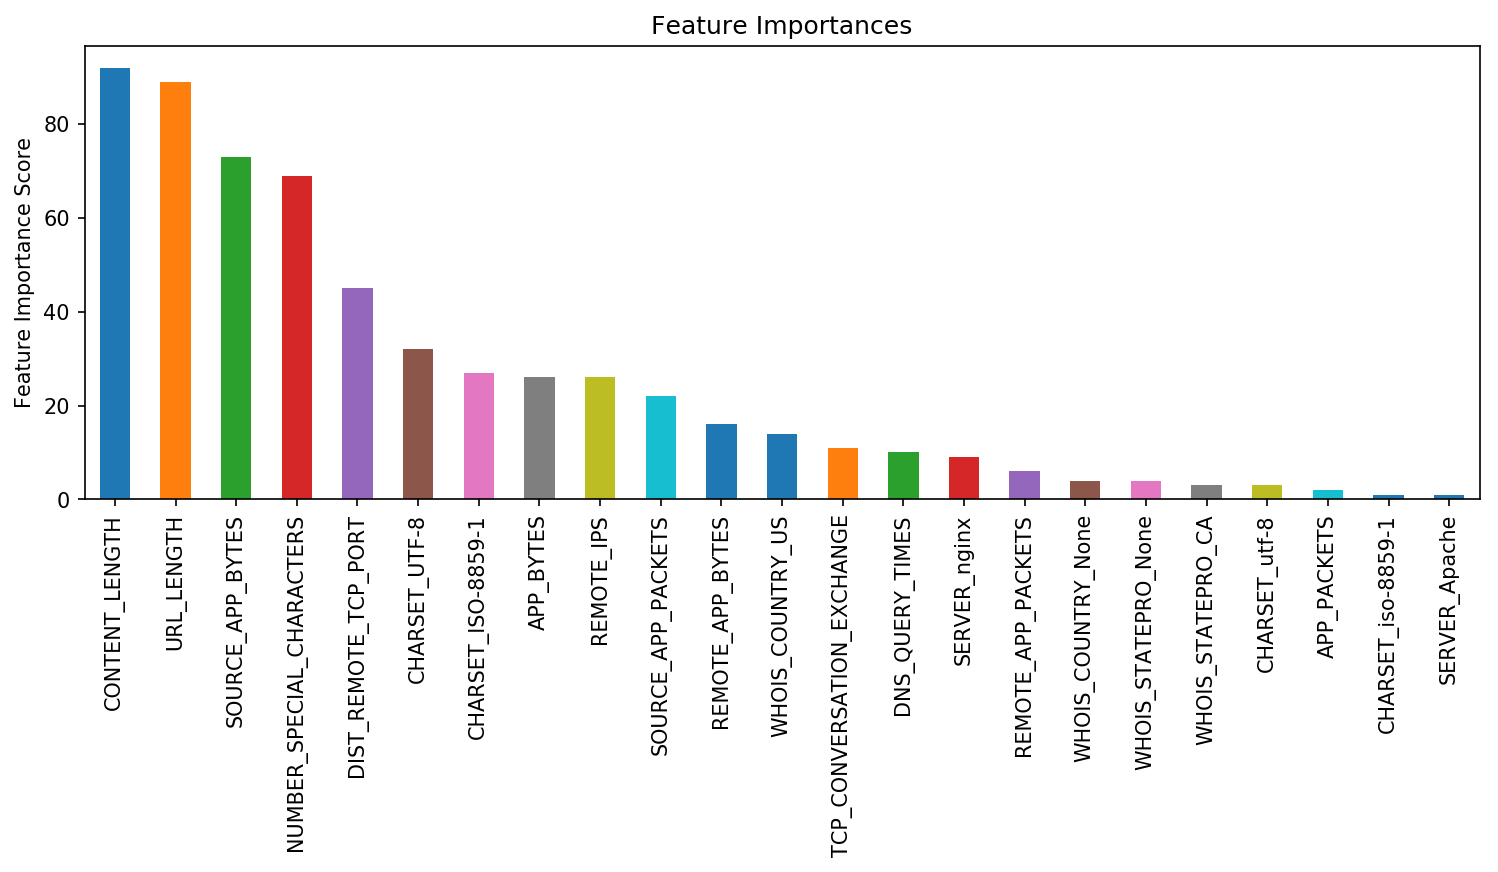

In [9]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.75,
 colsample_bytree=0.75,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

Best iteration:
test-auc-mean     0.971806
test-auc-std      0.005595
train-auc-mean    0.999924
train-auc-std     0.000065
Name: 146, dtype: float64

Model Report
Accuracy : 0.9969
AUC Score (Train): 0.999982


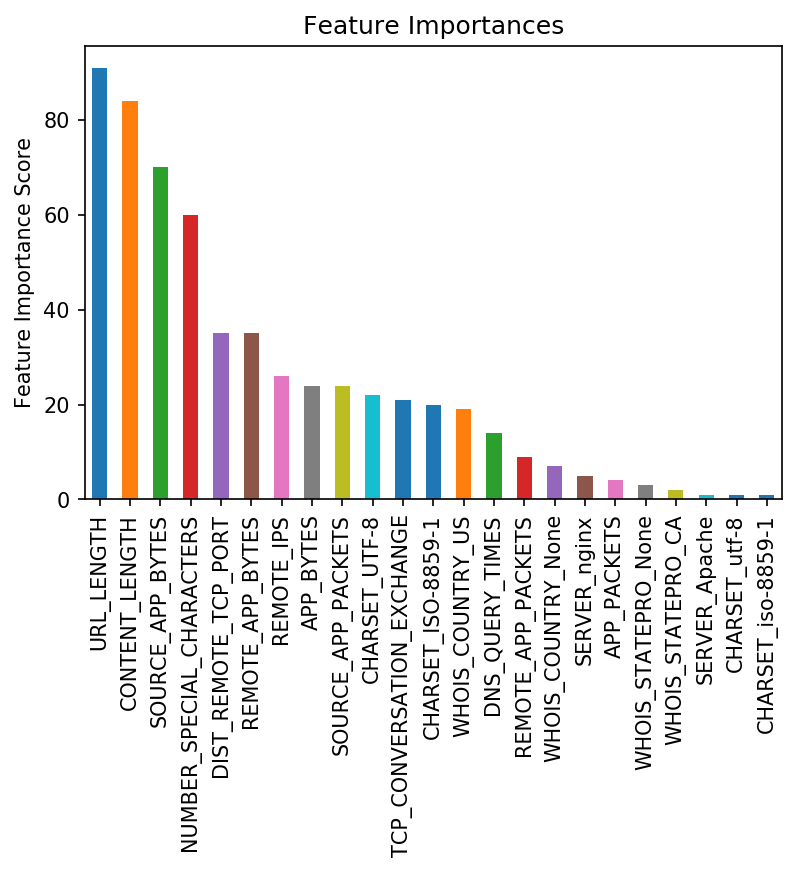

In [6]:
xgb4 = XGBClassifier(
 learning_rate =0.18,
 n_estimators=5000,
 max_depth=6,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.75,
 colsample_bytree=0.75,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

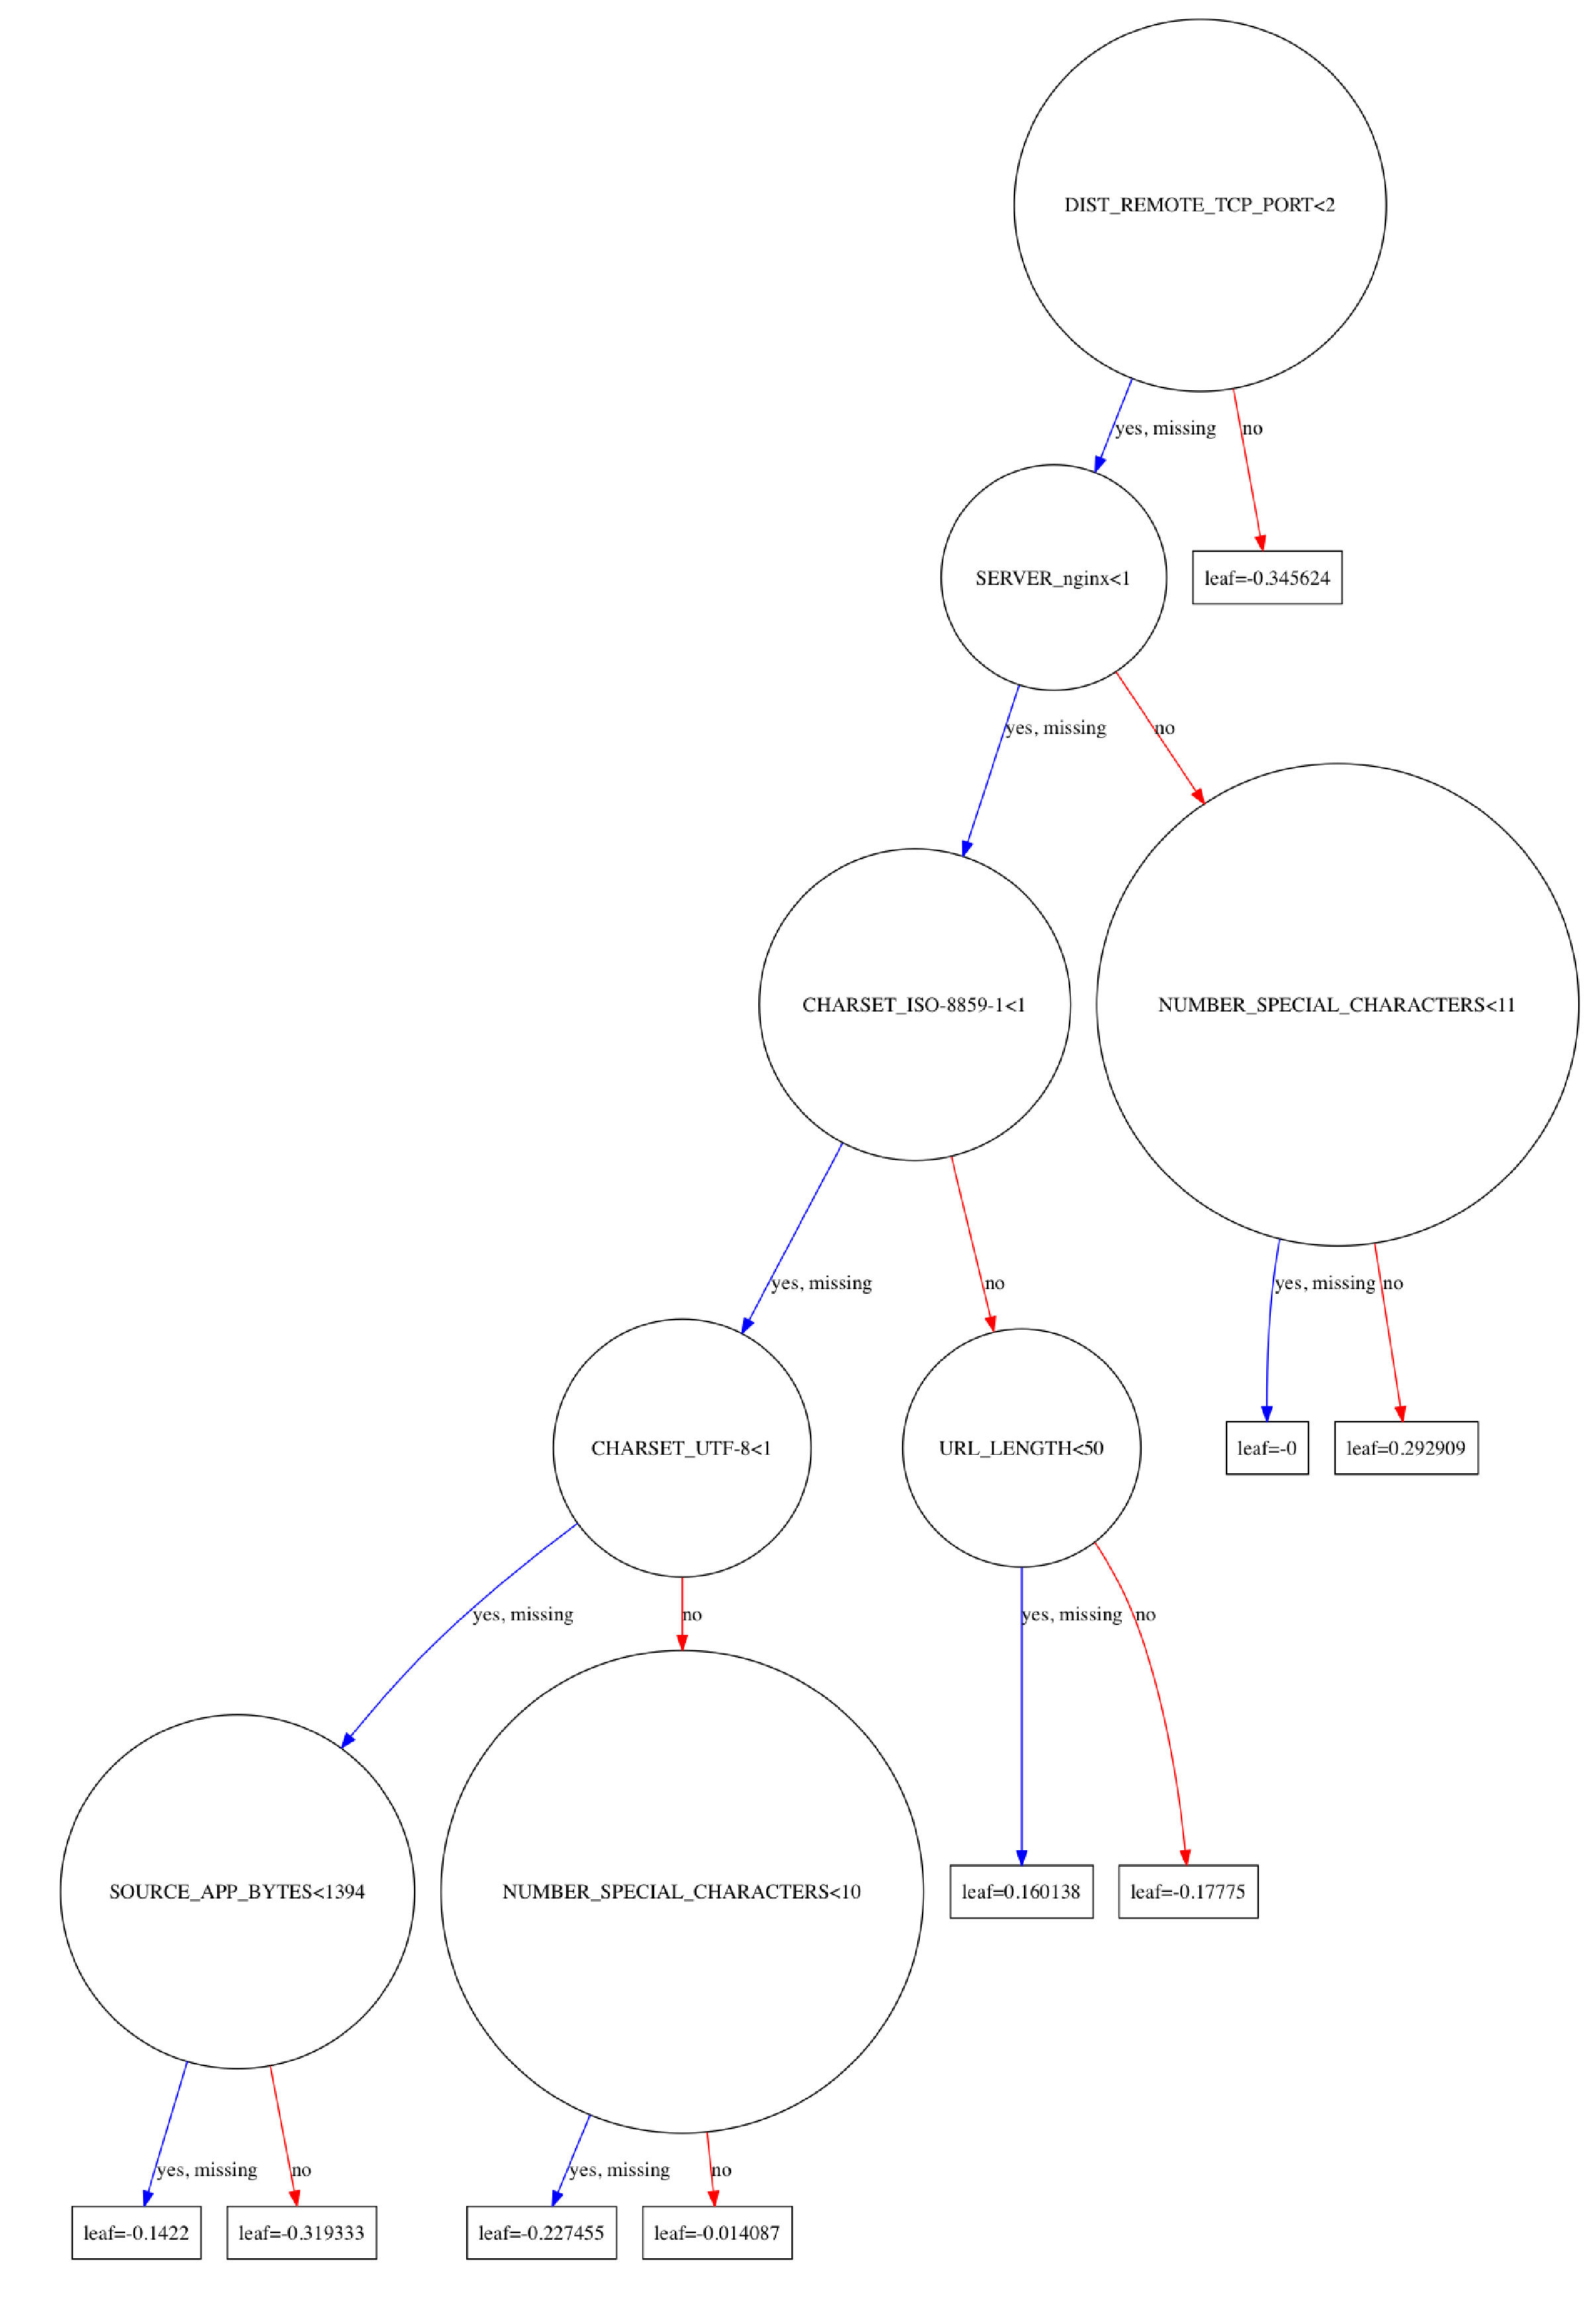

In [5]:
rcParams['figure.dpi'] = 150
plot_tree(xgb4)
fig = plt.gcf()
fig.set_size_inches(30,30)
plt.show()